In [1]:
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, Draw
from rdkit.Chem.rdmolops import FastFindRings
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger  
from rdkit import Chem
import matplotlib.pyplot as plt
from matplotlib import ticker

from tqdm import tqdm
import pandas as pd
import numpy as np
import math
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
from pylab import rcParams
RDLogger.DisableLog('rdApp.*') # removes annoying RDKit warnings

RDKit WARNING: [10:41:39] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
para = Chem.MolFromSmarts('*-!:c1ccc(*)cc1')
meta = Chem.MolFromSmarts('*-!:c1cc(*)ccc1')

### For an individual file:

In [63]:
df = pd.read_csv('../../../scripts/toy_model/sear_convergence/preds_supB_150k.txt', header=None, names=['SMILES'])
n_para=0
n_meta=0
n_invalid=0
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row['SMILES'].replace(" ", "")
#     print(smiles)
    try:
        mol = MolFromSmiles(smiles)
#         print(mol.HasSubstructMatch(para))
        if mol.HasSubstructMatch(para):
            n_para+=1
        if mol.HasSubstructMatch(meta):
            n_meta+=1
    except:
        n_invalid+=1
        
print("para-directing products: "+str(n_para))
print("meta-directing products: "+str(n_meta))
print("nonvalid products: "+str(n_invalid))

100%|██████████| 354/354 [00:00<00:00, 3189.88it/s]

para-directing products: 220
meta-directing products: 132
nonvalids products: 2


In [4]:
def return_counts(name):
    df = pd.read_csv(name, header=None, names=['SMILES'])
    n_para=0
    n_meta=0
    n_invalid=0
    size = len(df)
    if size==0:
        return 0, 0, 0
    for i,row in df.iterrows():
        smiles = row['SMILES'].replace(" ", "")
        try:
            mol = MolFromSmiles(smiles)
            if mol.HasSubstructMatch(para):
                n_para+=1
            if mol.HasSubstructMatch(meta):
                n_meta+=1
        except:
            n_invalid+=1

#     print("Number of para-directing products: "+str(n_para))
#     print("Number of meta-directing products: "+str(n_meta))
#     print("Number of ionvalids products: "+str(n_invalid))
    return n_para/size, n_meta/size, n_invalid/size

### Calculate para/meta counts for all 70 models:

In [73]:
N=7
M=10
para_counts = np.empty((3,N,M))
meta_counts = np.empty((3,N,M))
invalid_counts = np.empty((3,N,M))

names = ['Balanced','Biased','supBiased']
for k,name in enumerate(names):
    for i in range(N):
        for j in range(M):
            if name=='Balanced':
                fname = '../../../scripts/toy_model/sear_convergence/small/conv_sm_m'+str(j+1)+'_' + str(312*pow(2,i))+'.txt'
            if name=='Biased':
                fname = '../../../scripts/toy_model/sear_convergence/biased/conv_bi_m'+str(j+1)+'_' + str(156*pow(2,i))+'.txt'
            if name=='supBiased':
                fname = '../../../scripts/toy_model/sear_convergence/supBiased/conv_sB_m'+str(j+1)+'_' + str(152*pow(2,i))+'.txt'
            para_counts[k,i,j], meta_counts[k,i,j], invalid_counts[k,i,j] = return_counts(fname)

### Plot Generation:

In [74]:
rcParams['figure.figsize'] = 15, 9
rcParams.update({'errorbar.capsize': 7})
rcParams['lines.markersize'] = 10
rcParams['font.size'] = 17
rcParams["figure.dpi"] = 350

para/meta ratio for supBiased model: 0.8
para/meta ratio for supBiased model: 2.7
para/meta ratio for supBiased model: inf


/home/cdt1906/Applications/anaconda3/envs/mol_transformer2/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


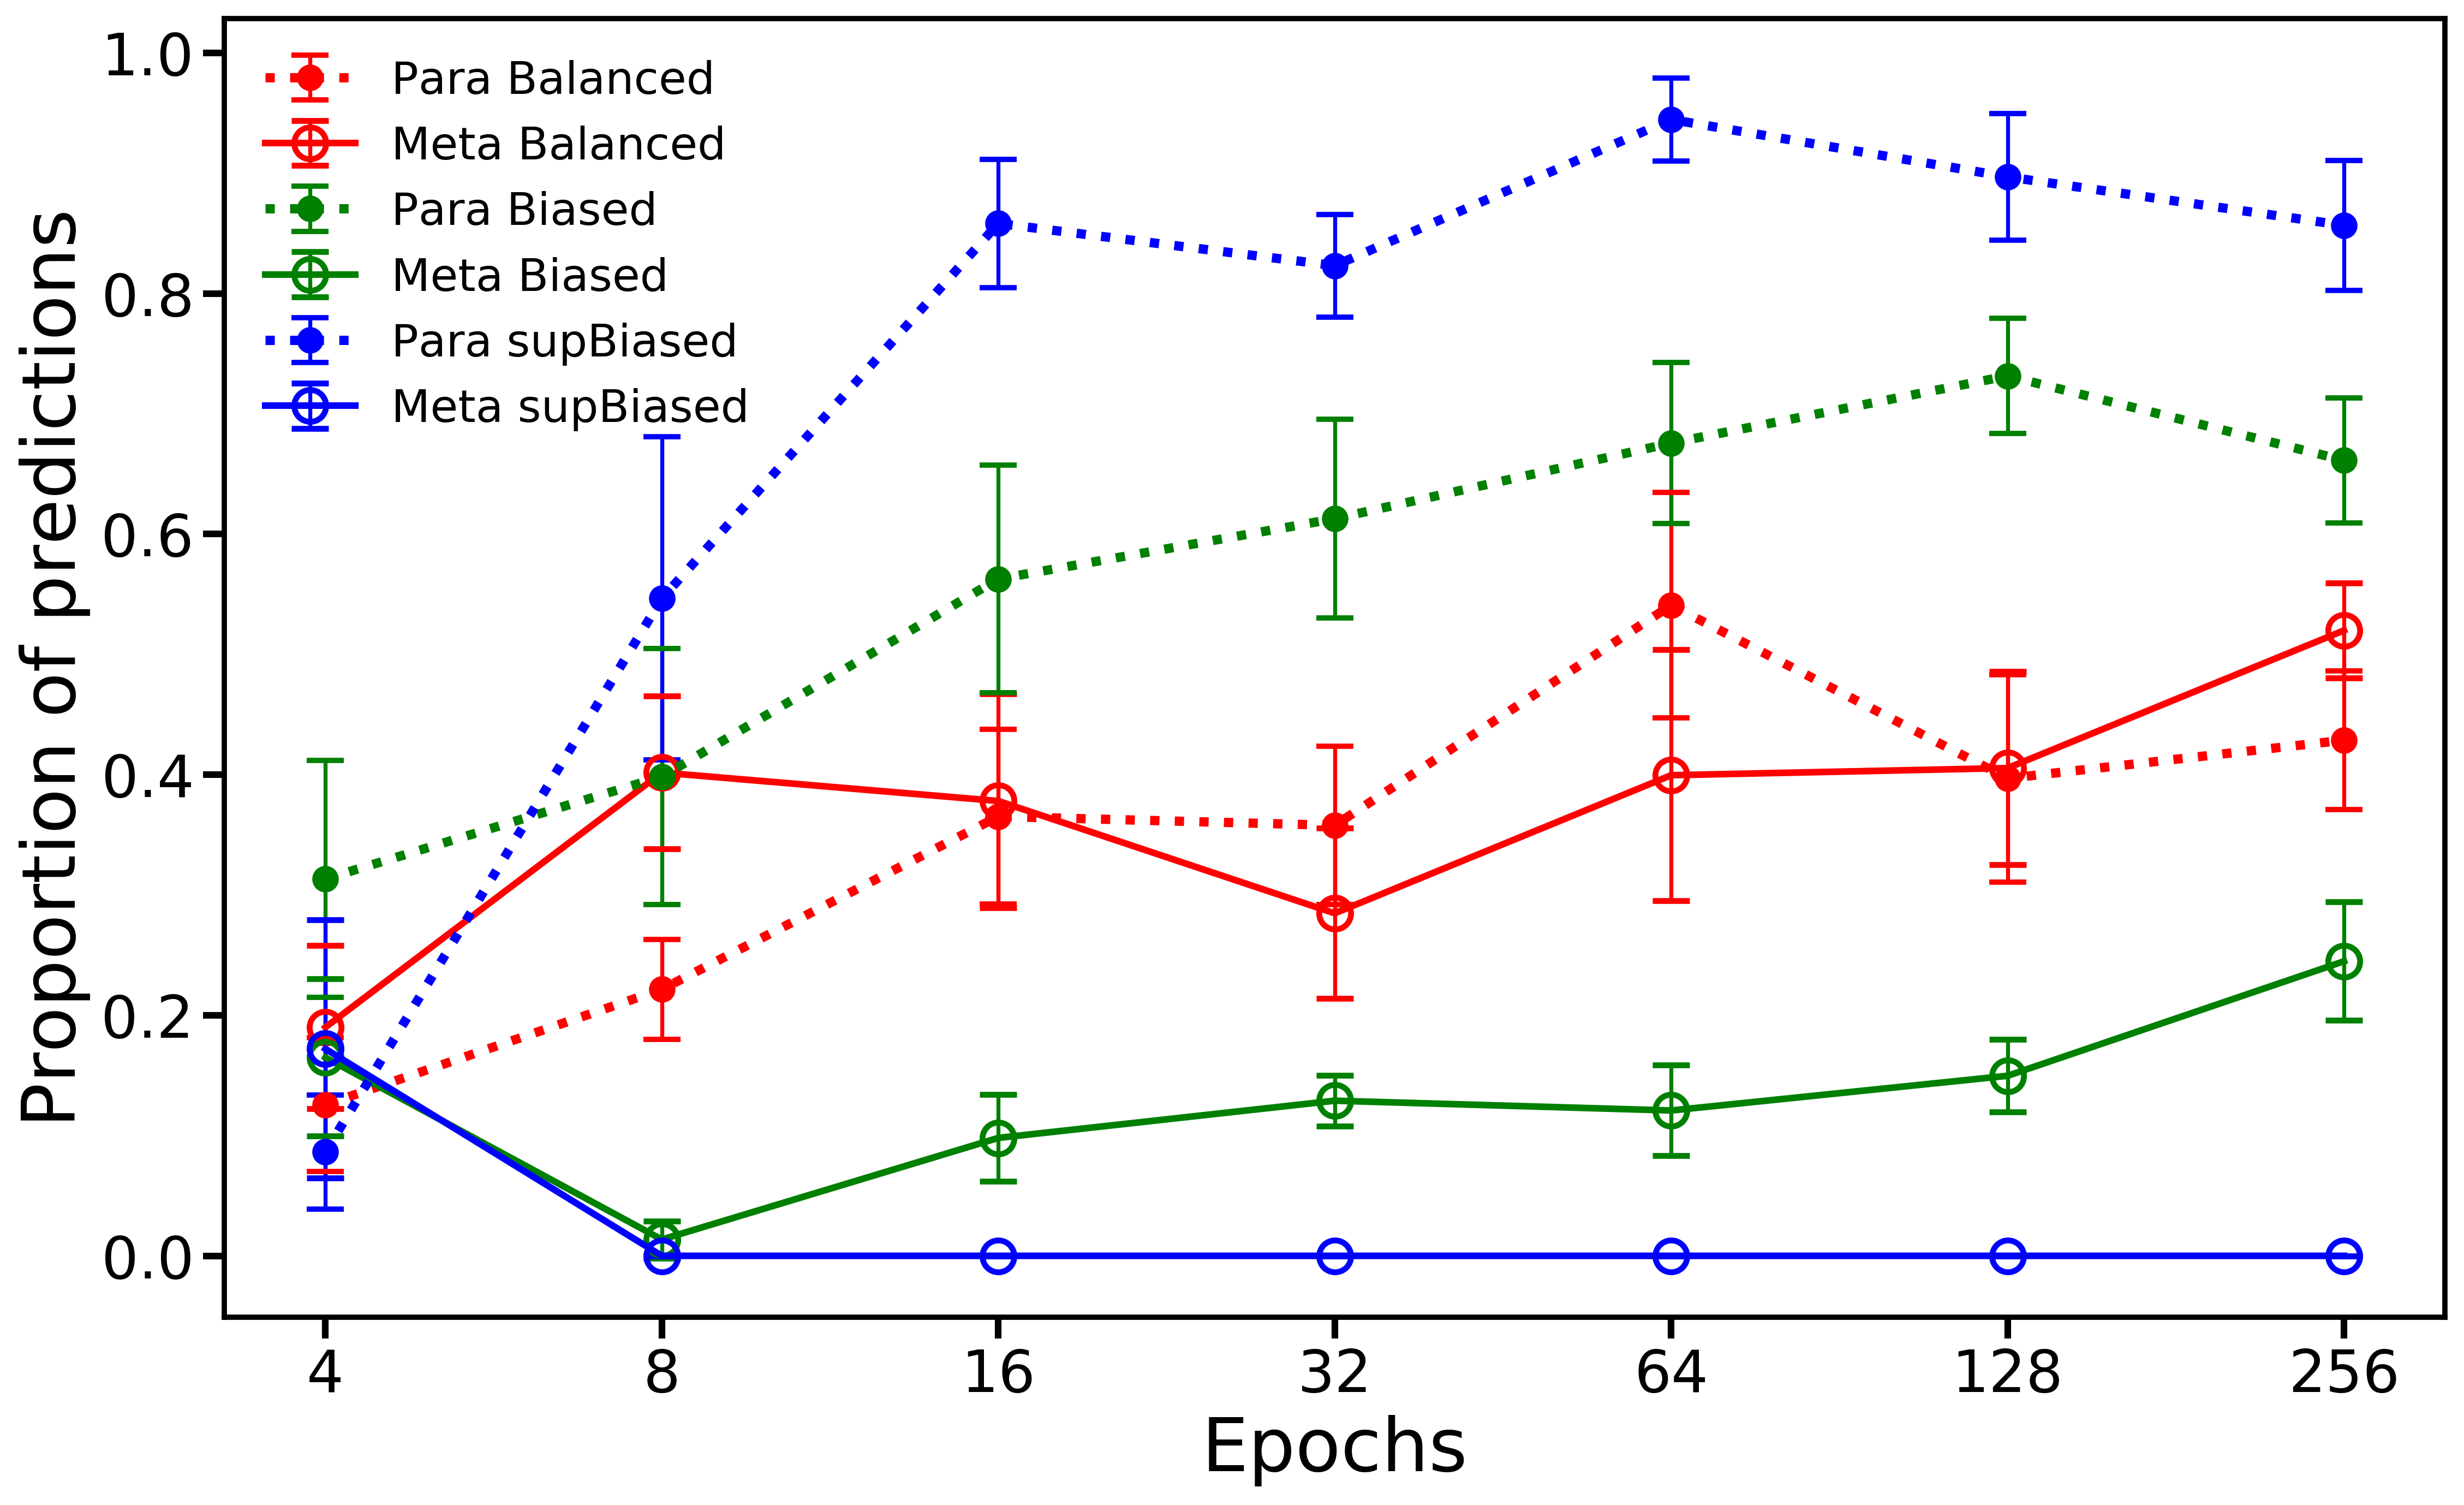

In [96]:
prop_cycle = plt.rcParams['axes.prop_cycle']
#colors = prop_cycle.by_key()['color']
colours = ['r', 'g', 'b']
epochs = np.logspace(2,8,7, base=2)
fig, axs = plt.subplots()

for k in range(3):
    x = np.mean(para_counts[k], axis=1)
    xerr = np.std(para_counts[k], axis=1)/np.sqrt(len(x))
    y = np.mean(meta_counts[k], axis=1)
    yerr = np.std(meta_counts[k], axis=1)/np.sqrt(len(y))
    print('para/meta ratio for {} model: {:.1f}'.format(name, x[-1]/y[-1]))
    
    axs.errorbar(epochs, x, yerr=xerr, label='Para '+names[k], lw=3.5, linestyle=':', 
                 marker='o', color=colours[k], elinewidth=1.5, capthick=2)
    axs.errorbar(epochs, y, yerr=yerr, label='Meta '+names[k], lw=2.5, linestyle='-', 
                 marker='o',color=colours[k], elinewidth=1.5, capthick=2, fillstyle='none', ecolor=colours[k],
                markeredgewidth=2.2, markersize=12)

axs.legend(loc='upper left', framealpha=0)
axs.set_xscale('log', basex=2)
axs.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
axs.set_ylabel('Proportion of predictions', fontsize=28)
axs.set_xlabel('Epochs', fontsize=28)
#axs.set_title('Para/Meta Counts as a function of epochs', fontsize=16)
axs.tick_params(axis='both', which='major', labelsize=22, length=8, width=2.5)
axs.spines['bottom'].set_linewidth(2.0)
axs.spines['top'].set_linewidth(2.0)
axs.spines['left'].set_linewidth(2.0)
axs.spines['right'].set_linewidth(2.0)
plt.savefig('synth_conv.png')
plt.show()
